# Game Sales Data Analysis

In this analysis, I will explore factors that influence video games success to help the online store, Ice, optimize its advertising campaigns for the 2017 year. Using a dataset with dates spanning from 1985 to 2016, I will use variables such as user reviews, genres, platforms (e.g., Xbox, PlayStation), sales data, and ESRB (Entertainment Software Rating Board) ratings. The ESRB ratings provide insights into the target audience by categorizing games based on content suitability, such as Teen or Mature.

The primary objective is to identify patterns and trends that determine whether a game succeeds in the market. By analyzing these factors, I will pinpoint most successful platforms and strategically plan advertising campaigns to maximize revenue in the next year. This analysis will help make future data-driven decisions to ensure Ice remains competitive in the rapidly evolving video game industry.

## Initializating and Preparing Data

In [1]:
# loading all the libraries
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display_html
from scipy import stats as st
import plotly.express as px
import seaborn as sns
import numpy as np

In [2]:
games = pd.read_csv('/datasets/games.csv'); games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


According to the documentation:
- `'Name'` — Name of the video game
- `'Platform'` — Platform of where the video game was released
- `'Year_of_Release '` — The year the video game was released
- `'Genre '` — The genre or category of the video game
- `'NA_Sales'` — Total sales of the video game in North America (in millions of units)
- `'EU_Sales'` — Total sales of the video game in Europe (in millions of units)
- `'JP_Sales'` — Total sales of the video game in Japan (in millions of units)
- `'Other_sales'` — Total sales of the video game in other regions (in millions of units)
- `'Critic_Score '` — Average score given by professional critics (0-100)
- `'User_Score '` — Average score given by users (typically on a scale of 0 to 10)
- `'Rating'` — The official content rating of the video game

In [3]:
games.columns = games.columns.str.lower() # lowercasing column names
games.duplicated(subset=['name', 'platform', 'year_of_release']).sum() # checking for duplicates

2

In [4]:
games = games.drop_duplicates(subset=['name', 'platform', 'year_of_release'])
games.isna().sum() # checking for missing values

name                  1
platform              0
year_of_release     269
genre                 1
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8577
user_score         6700
rating             6765
dtype: int64

In [5]:
# drop unnecessary values
games = games.dropna(subset=['year_of_release', 'name', 'genre'])
# converting data (with missing values) to required types
games['user_score'] = pd.to_numeric(games['user_score'].replace('tbd', np.nan), errors='coerce')
games['critic_score'] = pd.to_numeric(games['critic_score'], errors='coerce')
games['year_of_release'] = games['year_of_release'].astype(int)
games['user_score'] = pd.to_numeric(games['user_score']).astype(float)
# add a total sales column in the dataframe
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
games.info() # general summary/information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           9767 non-null   object 
 11  total_sales      16443 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


In the preparation phase, I addressed several issues to ensure the dataset was clean. First, I standardized all column names by converting them to lowercase for uniformity. Next, I identified and removed duplicate entries—specifically two rows that shared identical values for the game name, platform, and release year. Then, I addressed missing values across multiple variables, including `name`, `year_of_release`, `genre`, `critic_score`, `user_score`, and `rating`. Since missing values in `name`, `year_of_release`, and `genre` were minimal, I dropped these rows to maintain data integrity. For the `user_score` column, I treated entries marked as 'tbd' (to be determined) as missing values, as they could not be reliably imputed.

Additionally, I made the necessary data type conversions: changing `user_score` and `critic_score` from strings to floats to accommodate decimal values, and converting `year_of_release` to integers for proper numerical representation. Lastly, I created a new column, `total_sales`, which aggregates regional sales figures from North America, Europe, and Japan into a single metric.

These preprocessing steps have resulted in a clean, structured dataset that is now ready for in-depth analysis.

## Analyzing the Data

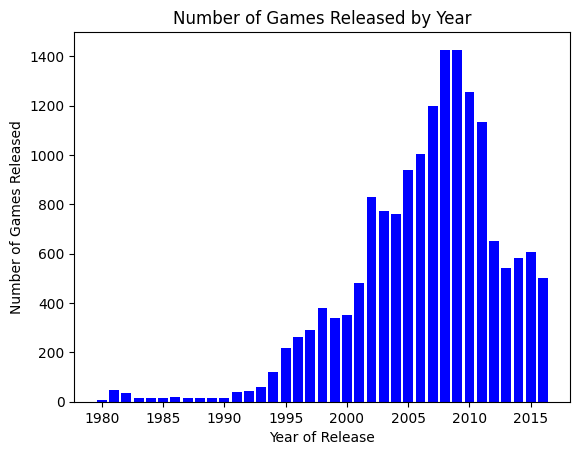

In [6]:
year_counts = games['year_of_release'].value_counts().reset_index().rename(
    columns={'index': 'year', 'year_of_release': 'count'})
plt.bar(year_counts['year'], year_counts['count'], color='blue')
plt.xlabel('Year of Release')
plt.ylabel('Number of Games Released')
plt.title('Number of Games Released by Year');

This bar chart shows clear trends in video game releases over time, illustrating the evolution of the industry. During the early years of gaming (1980–1990), the number of releases was low (under 200 games), as video games were still a niche market with limited technology and audience reach. However, the industry experienced great growth in years 2005–2010, with a sharp increase in releases as gaming became popular, technology advanced, and new platforms emerged. After 2010, the number of releases declined significantly, likely because of market saturation, rising development costs, and a shift toward fewer but higher-quality games.

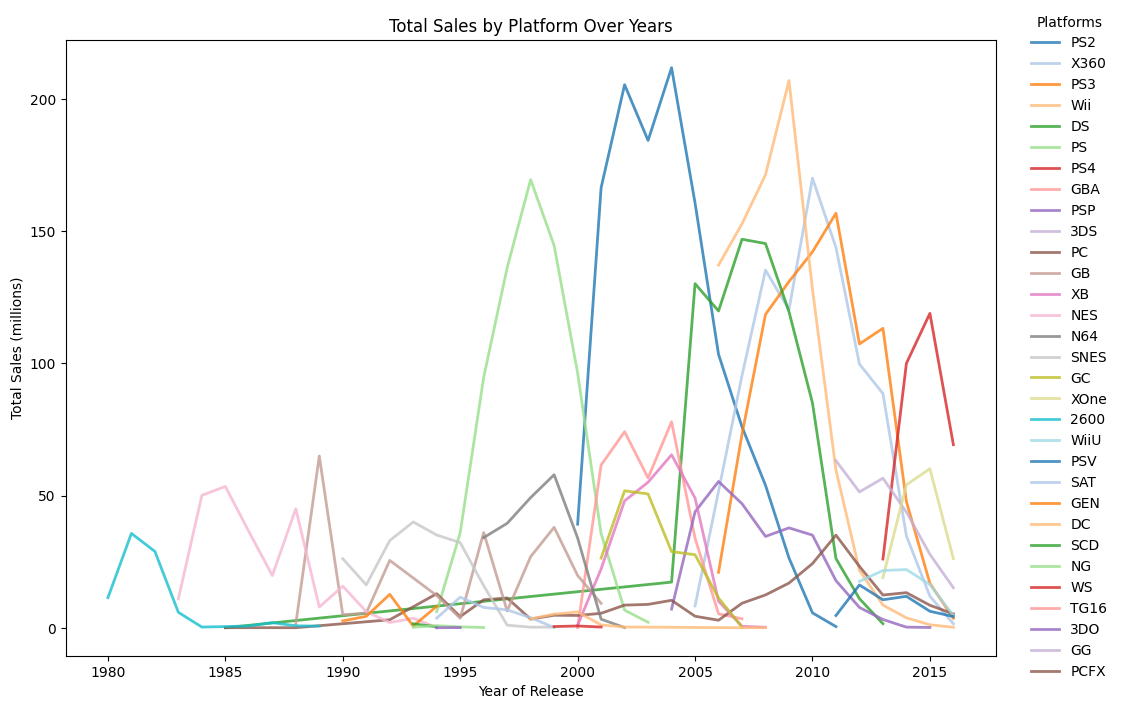

In [7]:
plt.figure(figsize=(12, 8))
top_sales = games.groupby('platform')['total_sales'].sum().sort_values(ascending=False).reset_index()
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)

for i in range(len(top_sales)):
    platform = top_sales['platform'][i]
    graph = games[games['platform'] == 
                  platform].groupby('year_of_release')['total_sales'].sum().reset_index()
    plt.plot(graph['year_of_release'], graph['total_sales'], label=f"{platform}", alpha=0.8, linewidth=2)

plt.xlabel('Year of Release')
plt.ylabel('Total Sales (millions)')
plt.title('Total Sales by Platform Over Years')
plt.legend(bbox_to_anchor=(1.025, 1.06), title='Platforms', frameon=False)
plt.show()

To start with the 2017 forecasting process, the line graph shows insight in platform lifecycles, historical trends, and market shifts. Platforms like the PS2, PSP, and DS were popular but now show zero sales, demonstrating how most gaming platforms have a 5 to 10-year lifespan. For instance, the original PlayStation (1995–2003) thrived during its peak but has since been replaced by newer platforms.

In addition, the total sales by platform is illustrated over time, aligning with the earlier bar chart and confirming that pre-2000s platforms had a low amount of sales and that many post-2010 platforms saw declining releases.

Given this trend, the data for earlier years (1980s–1990s) is not relevant for forecasting 2017 sales, as the industry's dynamics and consumer behavior have evolved substantially. Also, the sharp decline post-2010 must be accounted for, since this suggests changing business strategies in the gaming industry. To improve accuracy, the analysis should prioritize recent data and the average life of platforms, as it better reflects current industry conditions and consumer demand leading into 2017. Therefore, I will now only work with data only after the year 2012.

In [9]:
games.query('year_of_release>2011').pivot_table(index='year_of_release', columns='platform', 
                                               values='total_sales', aggfunc='sum')   

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.35,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


The pivot table shows the total sales trends across gaming platforms from 2012-2016. All platforms show declining sales, with previously popular ones like the DS and PSP dropping to zero sales, confirming our earlier observations about platform 5-10 year replacement cycle. However, three platforms come out as the most promising due to their sustained performance: the 3DS, PS4, and Xbox One. While these systems have a gradual decline, their 2016 sales (3DS: 15.14M, PS4: 69.25M, Xbox One: 26.15M) remained significantly above their competitors.

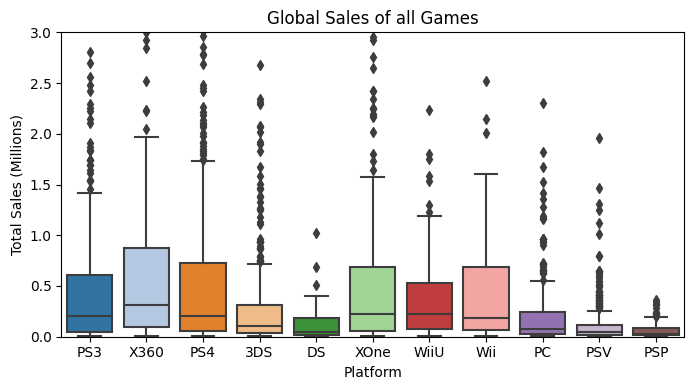

In [10]:
plt.figure(figsize=(7, 4))
games = games[games['year_of_release'] >= 2012]
sns.boxplot(x='platform', y='total_sales', data=games[['platform', 'total_sales']])
plt.title("Global Sales of all Games")
plt.xlabel("Platform")
plt.ylabel("Total Sales (Millions)")
plt.tight_layout()
plt.ylim(0,3)
plt.show()

Now that the data is adjusted, this box plot of total sales across platforms displays important information about the gaming industry from 2012-2016. Focusing on the 11 active platforms, we observe that while some individual games like PS3 achieved high sales, the median and average sales across all platforms consistently were far below the 5 million unit mark. This shows there are no statistically significant differences in average sales performance between platforms during these years. This holds true even the three most promising platforms (3DS, PS4, and Xbox One), whose median sales are close with other platforms despite their superior total sales. This suggests that while these platforms had more breakout hits, total sales performance was consistent regardless of platform. The contradiction between total sales and median figures implies that platform success was driven mostly by a handful of exceptional titles rather than consistent platform superiority.

3DS Correlations: User Score = 0.20, Critic Score = 0.32
PS4 Correlations: User Score = -0.03, Critic Score = 0.41
XOne Correlations: User Score = -0.07, Critic Score = 0.42


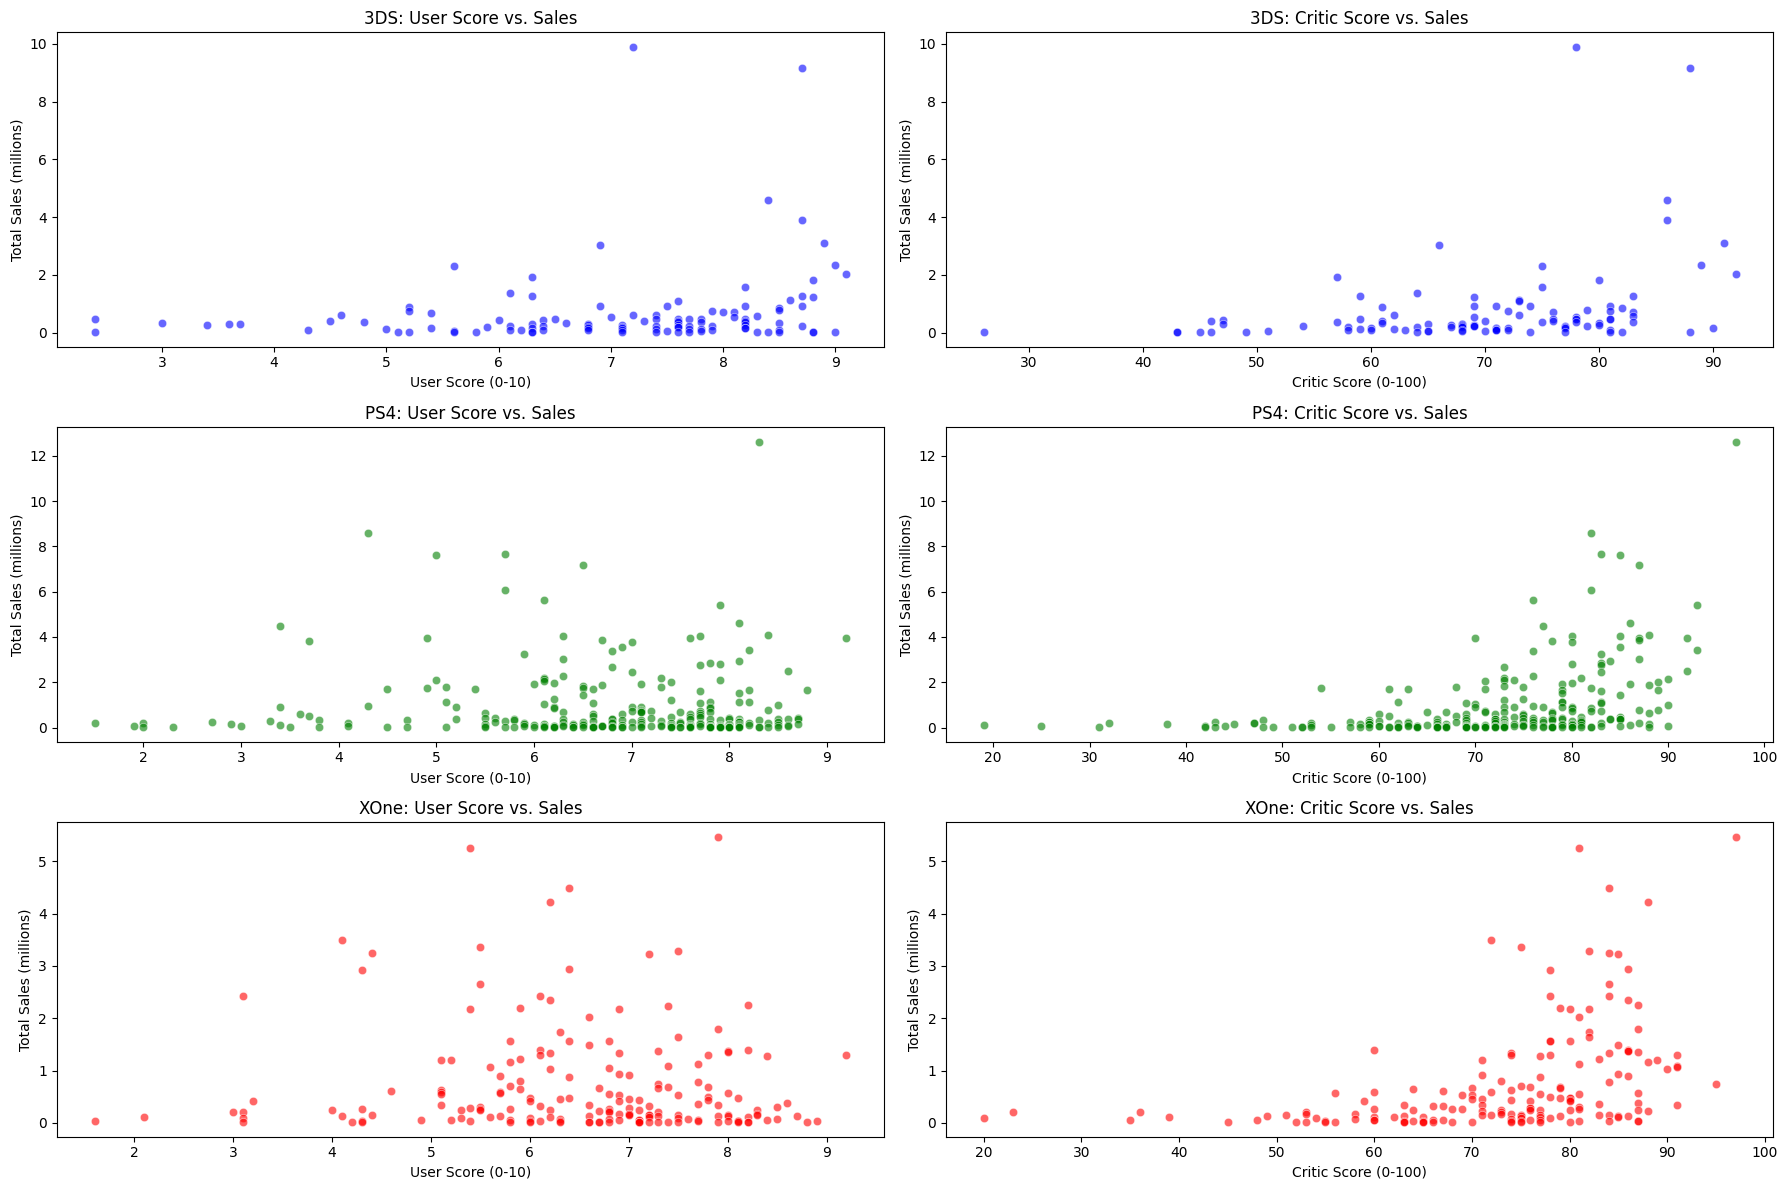

In [ ]:
promising = {'3DS': 'blue', 'PS4': 'green', 'XOne': 'red'}
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))

for i, (platform, color) in enumerate(promising.items()):
    data = games[games['platform'] == platform]
    
    sns.scatterplot(data=data, x='user_score', y='total_sales', 
                    ax=axes[i, 0], color=color, alpha=0.6)
    axes[i, 0].set_title(f'{platform}: User Score vs. Sales')
    axes[i, 0].set_xlabel('User Score (0-10)')
    axes[i, 0].set_ylabel('Total Sales (millions)')

    sns.scatterplot(data=data, x='critic_score', y='total_sales', 
                    ax=axes[i, 1], color=color, alpha=0.6)
    axes[i, 1].set_title(f'{platform}: Critic Score vs. Sales')
    axes[i, 1].set_xlabel('Critic Score (0-100)')
    axes[i, 1].set_ylabel('Total Sales (millions)')
    
    user_corr = data['user_score'].corr(data['total_sales'])
    critic_corr = data['critic_score'].corr(data['total_sales'])
    print(f"{platform} Correlations: User Score = {user_corr:.2f}, Critic Score = {critic_corr:.2f}")

plt.tight_layout()
plt.show()

The correlation analysis reveals distinct patterns in how reviews influence sales for our three focus platforms:

For the 3DS, there is a moderate positive correlations for both user scores (r=0.20) and critic scores (r=0.32). This balanced relationship suggests Nintendo's audience values both professional and community feedback when making purchases, though critic opinions appear slightly more influential. The clustering of most data points at lower sales levels shows that while reviews are important, other factors likely drive the majority of 3DS game performance.

The PS4 has a more different picture, with critic scores showing a positive correlation (r=0.41) while user scores have essentially no relationship (r=-0.03). This contrast implies that PlayStation buyers during this period placed significantly more trust in professional reviews than user ratings when evaluating games. The lack of positive user score correlation may show differences in how PlayStation audiences engage with review systems.

Lastly, the Xbox One shows the strongest critic correlation (r=0.42) among all platforms while displaying a slight negative relationship with user scores (r=-0.07). This contrast suggests that the Xbox audience not only prioritized critic opinions over user reviews, but that higher user scores sometimes even correlated with lower sales. Several potential explanations can include review bombing of popular titles or a disconnect between hardcore Xbox players and general user rating trends.

For marketers, these insights highlight the importance of platform-specific review strategies, with particular emphasis on getting strong critic evaluations for PlayStation and Xbox titles, while maintaining a broader review management approach for Nintendo platforms.

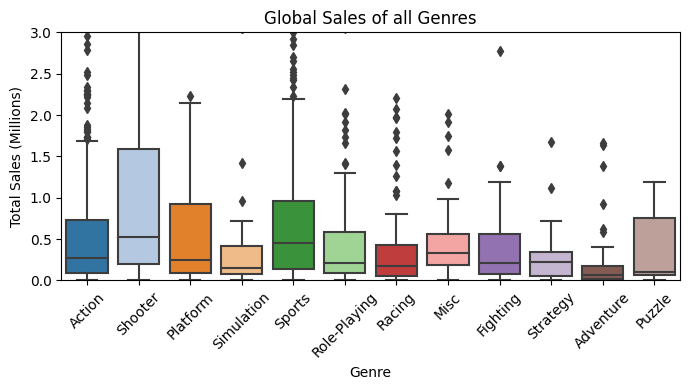

In [19]:
plt.figure(figsize=(7, 4))
sns.boxplot(x='genre', y='total_sales', data=games[['genre', 'total_sales']])
plt.title("Global Sales of all Genres")
plt.xlabel("Genre")
plt.ylabel("Total Sales (Millions)")
plt.xticks(rotation=45)
plt.ylim(0,3)
plt.tight_layout() 
plt.show()

This graph displays sales distribution across game genres. As shown in the data, nearly all 12 genres exhibit similar sales patterns with relatively low median sales figures, suggesting that most titles across categories sell modestly regardless of genre. However, there are quite a number of high-value outliers in each genre, illustrating that exceptional commercial success is possible in any category.

The shooter genre stands out as clearly the most consistently profitable, with both higher median sales and more frequent high-performing outliers compared to other genres. This suggests shooters have particularly strong market appeal and reliable commercial performance. Action and sports genres also show strong performance, though not to the same degree as shooters. At the other end of the spectrum, niche genres like puzzle, strategy, and simulation games show the most constrained sales distributions with few outliers, with a surprising show of role-playing as another genre with lots of hits.

These patterns suggest that while genre selection does influence sales potential, any kind of game can become popular. The presence of outliers across all genres imply that factors such as production quality and marketing are dependent on the games' success.

## Creating User Profile for each Region

To better understand global gaming trends, I will now analyze user preferences across three key regions: North America, Europe, and Japan. For each market, I will display the top 5 platforms, genres, and ESRB ratings to identify distinct patterns in consumer behavior.

In [12]:
def profile(x):
    na = games.groupby(x)['na_sales'].sum().reset_index().sort_values(
        by='na_sales', ascending=False).reset_index(drop=True).head()
    eu = games.groupby(x)['eu_sales'].sum().reset_index().sort_values(
        by='eu_sales', ascending=False).reset_index(drop=True).head()
    jp = games.groupby(x)['jp_sales'].sum().reset_index().sort_values(
        by='jp_sales', ascending=False).reset_index(drop=True).head()
        
    na_cap = na.style.set_caption("North America").format({'na_sales': '{:.2f}'})
    eu_cap = eu.style.set_caption("Europe").format({'eu_sales': '{:.2f}'})
    jp_cap = jp.style.set_caption("Japan").format({'jp_sales': '{:.2f}'})
    
    combine = (na_cap.render() + eu_cap.render() + jp_cap.render())
    display_html(combine.replace(
        'table', 'table style="display:inline-block; margin-right:20px;"'), raw=True)

### Top Five Platforms

In [13]:
profile('platform')

,platform,na_sales
0,X360,140.05
1,PS4,108.74
2,PS3,103.38
3,XOne,93.12
4,3DS,55.31
,platform,eu_sales
0,PS4,141.09
1,PS3,106.85
2,X360,74.52
3,XOne,51.59


These tables reveal distinct platform preferences across North America, Europe, and Japan. The PS4, PS3, and 3DS consistently rank among the top platforms in all three regions, demonstrating their global appeal. However, North America leads in total sales volume, likely due to its larger market size, with their top platform X360 at 140M sales. Japan shows unique preferences, with the 3DS ranking highest, suggesting the country's preference for Nintendo's systems. These insights suggest that while PlayStation and Nintendo systems have broad international success, platform strategies must be tailored regionally. 

### Top Five Genres

In [14]:
profile('genre')

,genre,na_sales
0,Action,177.84
1,Shooter,144.77
2,Sports,81.53
3,Role-Playing,64.00
4,Misc,38.19
,genre,eu_sales
0,Action,159.34
1,Shooter,113.47
2,Sports,69.08
3,Role-Playing,48.53


These tables show differences in genre popularity across the three regions. Action games dominate Western markets, claiming the top spot in both North America (177.84M sales) and Europe (159.34M sales), followed by the shooter grenre. Japan, however, has a distinct profile, with role-playing games (RPGs) leading at 65.44M sales, almost double the action genre's performance there (52.80M). Intrestingly, sports rank third in both North America and Europe but are not in Japan's top five, with niche categories like simulation and fighting games. This divergence highlights Japan's unique gaming culture, which favors narrative-driven and stylized experiences over realistic sports simulations. These insights reveal that while action games have universal appeal, regional strategies must adapt to cultural preferences.

### Top ESRB Ratings

In [15]:
profile('rating')

,rating,na_sales
0,M,231.57
1,E,114.37
2,E10+,75.70
3,T,66.02
,rating,eu_sales
0,M,193.96
1,E,113.02
2,E10+,55.37
3,T,52.96
,rating,jp_sales


These tables show ESRB rating preferences across regions. In Western markets, mature-rated (M) games dominate sales, with North America generating 231.57 million and Europe 193.96 million in M-rated game sales - around double their respective E-rated game revenues. This strong preference for adult-oriented content is very different from Japan's market, where E-rated games have 28.33 million in sales, while M-rated games are third on the rank. These patterns highlight the importance of tailoring age-appropriate content strategies to each market's cultural norms for future release of games.

## Testing Hypotheses

Here, I will conduct a hypothesis test to evaluate whether there is a statistically significant difference between two key variables in the dataset. Specifically, I will compare the average user ratings between Xbox One and PC platforms, as well as Action and Sports genres. 

To test this, I will use a two-tailed test with a significance level (α) of 0.05. This approach will help determine whether the differences in average user ratings are statistically significant or due to random variation. The findings will provide valuable insights into whether one platform or genre consistently receives higher user ratings than the other.

### Average user ratings of the Xbox One and PC platforms are the same

Null Hypothesis (H₀): There is no significant difference in the average user ratings of the Xbox One and PC platforms.

Alternative Hypothesis (H₁): There is a significant difference in the average user ratings of the Xbox One and PC platforms.

In [16]:
games = games.dropna(subset=['user_score']) 
xbox = games[games['platform'] == 'XOne']['user_score']
pc = games[games['platform'] == 'PC']['user_score']
results = st.ttest_ind(xbox, pc, equal_var=False)

if (results.pvalue < 0.05):
    print(f'We reject the null hypothesis since the p-value is {results.pvalue}')
else:
    print(f"We fail to reject the null hypothesis since the p-value is {results.pvalue}")

We fail to reject the null hypothesis since the p-value is 0.5489537965134912


As shown by the p-value, it is drastically over 0.05, meaning that null hypothesis cannot be rejected. Therefore, there is no significant difference between the average user ratings in the Xbox One and PC platforms.

### Average user ratings for the Action and Sports genres are different

Null Hypothesis (H₀): There is no significant difference in the average user ratings of the Action and Sports genres.

Alternative Hypothesis (H₁): There is a significant difference in the average user ratings of the Action and Sports genres.

In [17]:
action = games[games['genre'] == 'Action']['user_score']
sports = games[games['genre'] == 'Sports']['user_score']
results = st.ttest_ind(action, sports, equal_var=False)

if (results.pvalue < 0.05):
    print(f'We reject the null hypothesis since the p-value is {results.pvalue}')
else:
    print(f"We fail to reject the null hypothesis since the p-value is {results.pvalue}")

We reject the null hypothesis since the p-value is 5.989458066467418e-20


As shown by the p-value, it is below 0.05, meaning that the null hypothesis is rejected. Therefore, there is a significant difference between the average user ratings in the Action and Sports genre.

## Conclusion

Based on the analysis of gaming trends from 1980-2016, we forecast that 2017 sales will be dominated by current-generation platforms like the PS4 and Xbox One in Western markets and the Nintendo Switch in Japan, following the industry's 5-10 year platform lifecycle, with shooters and action games lead in North America and Europe while RPGs are most popular in Japan. The presence of outliers for popular games were across all genres, suggesting that quality execution and marketing can drive hits even in less popular categories. In addition, regional differences in ESRB rating preferences - with Western markets favoring M-rated content and Japan preferring E-rated games - highlight the need for cultural adaptation.